In [3]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from itertools import cycle
import numpy as np
import pandas as pd
import re
import os
import torch
#torch.cuda.current_device() 
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, mean_squared_error, precision_recall_curve
import argparse
import pickle
import time
start_time = time.time()

In [4]:
# set random seed
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed_all(0)

In [5]:
# construct dataset
print("construct dataset")
class Dataset(Dataset):
    def __init__(self, input_data, input_label):
        data = []
        for i,j in zip(input_data, input_label):
            data.append((i,j))
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        d, l = self.data[index]
        return d, l

construct dataset


In [215]:
#define model
class DNN(nn.Module):
    def __init__(self):
        super(DNN,self).__init__()
        self.encoder  =  nn.Sequential(
            nn.Linear(input_dim,1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        return x

In [216]:
# define and plot confusion matrix
def get_confusion_matrix(trues, preds):
    labels = [0,1,2,3,4,5,6,7,8,9]
    conf_matrix = confusion_matrix(trues, preds)
    return conf_matrix
  
def plot_confusion_matrix(conf_matrix, path):
    plt.imshow(conf_matrix, cmap=plt.cm.Greens)
    indices = range(conf_matrix.shape[0])
    labels = [0,1]
    plt.xticks(indices, labels)
    plt.yticks(indices, labels)
    plt.colorbar()
    plt.xlabel('y_pred')
    plt.ylabel('y_true')
    # 显示数据
    for first_index in range(conf_matrix.shape[0]):
        for second_index in range(conf_matrix.shape[1]):
            plt.text(first_index, second_index, conf_matrix[first_index, second_index])
    #plt.savefig(path + os.sep + 'heatmap_confusion_matrix.png', dpi = 400)
    plt.show()    

In [412]:
if __name__ == '__main__':

    #将参数定义好并封装
#     parser = argparse.ArgumentParser()
#     parser.add_argument('--data', type=str, help = 'input train data file path')
#     parser.add_argument('--test', type=str, help = 'input test data file path')
#     parser.add_argument('--output', type=str, help = 'output relevant result file path')
#     parser.add_argument('--epoch', type=int, help = 'train epoch')
#     parser.add_argument('--lr', type=float, help = 'train learning rate')
#     opt = parser.parse_args()         
    
    # 读取数据
    #data = pd.read_excel('..../key_gene_train_random_set.xlsx', sheet_name = 'data', header = 0)
    data = pd.read_excel('.../Pipeline/PHI_dna_prot_feat_update.xlsx', sheet_name = 'data', header = 0)
    #data = pd.read_excel('.../PHI_dna_prot_feat.xlsx', sheet_name = 'dna_prot_feature_Kmeans', header = 0)
    #data = pd.read_csv('.../key_CDD_kmeans.csv', header = 0)
    #test = pd.read_excel('.../key_gene_union_test_set.xlsx', sheet_name = 'data', header = 0)
    #test = pd.read_csv('.../key_CDD_kmeans.csv', header = 0)
    test = pd.read_excel('.../Pipeline/wgs_test_set.xlsx', sheet_name = 'data', header = 0)
    #test = pd.read_excel('...\\external\\case.xlsx', sheet_name = 'key_gene_PHI', header = 0)
    #test = pd.read_excel('.../test_set.xlsx', sheet_name = 'dna_prot_feat_kmeans', header = 0)
    #test = pd.read_excel('...\\external\\external_PHI.xlsx', sheet_name = 'data', header = 0)
    data


    print("加载数据")
    #data, label = data.iloc[:,:-1], data.iloc[:,-1]
    train_data, train_label = data.iloc[:,:-1], data['label']
    test_data, test_label = test.iloc[:,:-1], test['label']
    #scaler = StandardScaler()
    #data = scaler.fit_transform(data)
    #train_data, test_data, train_label, test_label = train_test_split(data, label, test_size=.3, random_state=123)
    stdScale = StandardScaler().fit(train_data)
    train_data = stdScale.transform(train_data)
    test_data = stdScale.transform(test_data)
    pickle.dump(stdScale, open('.../result/wgs_scaler.pkl', 'wb'))
    train_data, test_data, train_label, test_label = np.asarray(train_data), np.asarray(test_data), np.asarray(train_label), np.asarray(test_label)
    print('训练数据：', train_data.shape)
    print('测试数据：', test_data.shape)

加载数据
训练数据： (2422, 2676)
测试数据： (4924, 2676)


In [401]:
# 定义相关参数
print("定义相关参数")
epochs = 30
batch_size = train_data.shape[0]
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
torch.backends.cudnn.enable =True
input_dim = train_data.shape[1]

定义相关参数


In [402]:
# 数据加载器
trainDataset = Dataset(train_data, train_label)
testDataset = Dataset(test_data, test_label)
# print(trainDataset[0])
# print(trainDataset[0])
trainDataLoader = DataLoader(trainDataset, batch_size=batch_size, shuffle=True, num_workers=0)
testDataLoader = DataLoader(testDataset, batch_size=batch_size, shuffle=False, num_workers=0)

In [403]:
# 定义损失函数、优化器和初始化相关参数
model = DNN()
print(model)
model.to(device)

print("定义损失函数、优化器")
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=1e-4)

print("初始化相关参数")
for param in model.parameters():
    nn.init.normal_(param, mean=0, std=0.01)

DNN(
  (encoder): Sequential(
    (0): Linear(in_features=2676, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=128, bias=True)
    (7): ReLU()
    (8): Linear(in_features=128, out_features=64, bias=True)
    (9): ReLU()
    (10): Linear(in_features=64, out_features=1, bias=True)
    (11): Sigmoid()
  )
)
定义损失函数、优化器
初始化相关参数


开始训练主循环


C:\Users\admin\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[sklearn_metrics] Epoch:0 loss:0.6931
0.4874933475252794 0.2437466737626397 0.5 0.32772808586762076
[sklearn_metrics] Epoch:1 loss:0.6931
0.5125066524747206 0.2562533262373603 0.5 0.33884588318085856
[sklearn_metrics] Epoch:2 loss:0.6930
0.5125066524747206 0.2562533262373603 0.5 0.33884588318085856
[sklearn_metrics] Epoch:3 loss:0.6929
0.5125066524747206 0.2562533262373603 0.5 0.33884588318085856
[sklearn_metrics] Epoch:4 loss:0.6925
0.5125066524747206 0.2562533262373603 0.5 0.33884588318085856
[sklearn_metrics] Epoch:5 loss:0.6702
0.5125066524747206 0.2562533262373603 0.5 0.33884588318085856
[sklearn_metrics] Epoch:6 loss:0.8656
0.5125066524747206 0.2562533262373603 0.5 0.33884588318085856
[sklearn_metrics] Epoch:7 loss:0.6930
0.5125066524747206 0.2562533262373603 0.5 0.33884588318085856
[sklearn_metrics] Epoch:8 loss:0.6929
0.5125066524747206 0.2562533262373603 0.5 0.33884588318085856
[sklearn_metrics] Epoch:9 loss:0.6932
0.5125066524747206 0.576797385620915 0.5229909489540964 0.4162

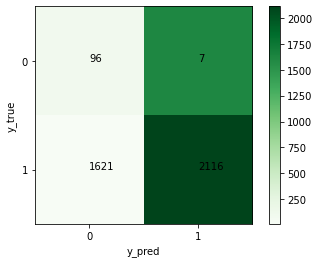

[sklearn_metrics] accuracy:0.5760 precision:0.7491 recall:0.5263 f1:0.4138


In [404]:
# 进行训练和测试
print("开始训练主循环")
model.train()
for epoch in range(epochs):
    tot_loss = 0.0
    train_preds = []
    train_trues = []
    # model.train()
    for i,(train_data_batch, train_label_batch) in enumerate(trainDataLoader):
        train_data_batch = train_data_batch.float().to(device) # 将double数据转换为float
        train_label_batch = train_label_batch.to(device)
        outputs = model(train_data_batch)
        outputs = outputs.squeeze(dim=-1)
        # _, preds = torch.max(outputs.data, 1)
        loss = criterion(outputs, train_label_batch.float())
        # print(loss)
        #反向传播优化网络参数
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        #累加每个step的损失
        tot_loss += loss.data
        train_outputs = outputs.ge(0.5).float()

        train_preds.extend(train_outputs.cpu().numpy())
        train_trues.extend(train_label_batch.detach().cpu().numpy())


    sklearn_accuracy = accuracy_score(train_trues, train_preds) 
    sklearn_precision = precision_score(train_trues, train_preds, average='macro')
    sklearn_recall = recall_score(train_trues, train_preds, average='macro')
    sklearn_f1 = f1_score(train_trues, train_preds, average='macro')
    print("[sklearn_metrics] Epoch:{} loss:{:.4f}".format(epoch, tot_loss))
    print(sklearn_accuracy, sklearn_precision, sklearn_recall, sklearn_f1)


test_preds = []
test_trues = []
test_probs = []
torch.save(model.state_dict(), 'E:/公共数据/result/rbp_random_model.pth')
model.eval()
with torch.no_grad():
    for i,(test_data_batch, test_data_label) in enumerate(testDataLoader):
        test_data_batch = test_data_batch.float().to(device) # 将double数据转换为float
        test_data_label = test_data_label.to(device)
        test_outputs = model(test_data_batch)
        test_output = test_outputs.ge(0.5).float()
        test_preds.extend(test_output.detach().cpu().numpy())
        test_trues.extend(test_data_label.detach().cpu().numpy())
        test_probs.extend(test_outputs.detach().cpu().numpy())

    sklearn_accuracy = accuracy_score(test_trues, test_preds)
    sklearn_precision = precision_score(test_trues, test_preds, average='macro')
    sklearn_recall = recall_score(test_trues, test_preds, average='macro')
    sklearn_f1 = f1_score(test_trues, test_preds, average='macro')

    print(classification_report(test_trues, test_preds))
    conf_matrix = get_confusion_matrix(test_trues, test_preds)
    print(conf_matrix)
    plot_confusion_matrix(conf_matrix, '')
    print("[sklearn_metrics] accuracy:{:.4f} precision:{:.4f} recall:{:.4f} f1:{:.4f}".format(sklearn_accuracy, sklearn_precision, sklearn_recall, sklearn_f1))

AUPR :  0.8541408773083137
AUC :  0.8519605694187218


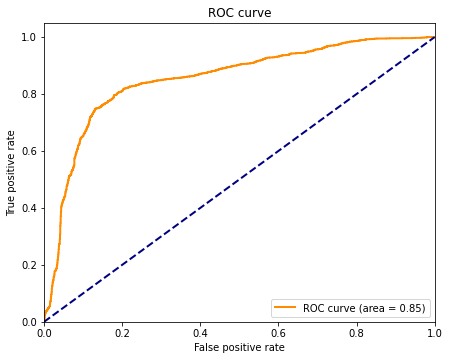

--- 2901.119217157364 seconds ---


In [405]:
precision, recall, _thresholds = precision_recall_curve(test_label,test_probs)
roc_auc = auc(recall, precision)
print("AUPR : ", roc_auc)

# 二分类　ＲＯＣ曲线
# roc_curve:真正率（True Positive Rate , TPR）或灵敏度（sensitivity）
# 横坐标：假正率（False Positive Rate , FPR）
fpr, tpr, thresholds_keras = roc_curve(test_trues, test_probs)
roc_auc = auc(fpr, tpr)
print("AUC : ", roc_auc)
plt.subplots(figsize=(7,5.5));
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
#plt.savefig(opt.output + os.sep + "ROC.png", dpi = 400)
plt.show()

print("--- %s seconds ---" % (time.time() - start_time))

In [406]:
res = pd.DataFrame()
res['label'] = test_trues
for i in range(len(test_preds)):
    test_preds[i] = test_preds[i][0]
    test_probs[i] = test_probs[i][0]
res['pred'] = test_preds
res['prob'] = test_probs
res

,label,pred,prob
0,1,1.0,0.739562
1,1,1.0,0.706634
2,1,1.0,0.709106
3,1,1.0,0.712329
4,1,1.0,0.755265
...,...,...,...
3835,0,1.0,0.585164
3836,0,1.0,0.521965
3837,0,1.0,0.696294
3838,0,1.0,0.695427


In [418]:
model(torch.tensor(test_data).to(device).float()).detach().cpu().numpy().flatten()

array([0.66925704, 0.6452694 , 0.67241865, ..., 0.6435786 , 0.5299428 ,
       0.5269049 ], dtype=float32)

In [407]:
res.to_csv('.../result/rbp_test_random.csv', index = False)

In [416]:
model(torch.tensor(test_data[0]).to(device).float())

tensor([0.6693], device='cuda:0', grad_fn=<SigmoidBackward>)